In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import lookahead
import numpy as np

import random

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import trange

from TorchCoder import *

In [2]:
# Create data point
def generate_data_point(dt=0.001, noisy=True):
    f1, f2 = random.randint(1, 100), random.randint(1, 100)
    t = torch.tensor(np.arange(0,1,dt)).float(); n=len(t)
    f = torch.sin(2*torch.pi*f1*t) + torch.sin(2*torch.pi*f2*t) # Sum of 2 frequencies
    f_clean = f
    if noisy: 
        f = f + 2.5*torch.randn(len(t)) # Add some noise
    return f, f_clean

# Create dataset
def generate_dataset(n_samples=1000, dt=0.001):
    f_data = []
    f_clean_data = []
    for i in range(n_samples):
        f, f_clean = generate_data_point(dt=dt, noisy=True)
        f = f.unsqueeze(-1)
        f_clean = f_clean.unsqueeze(-1)
        f_data.append(f)
        f_clean_data.append(f_clean)
    return torch.cat(f_data, dim=1).T, torch.cat(f_clean_data, dim=1).T

In [3]:
f_data, f_clean_data = generate_dataset(n_samples=100)

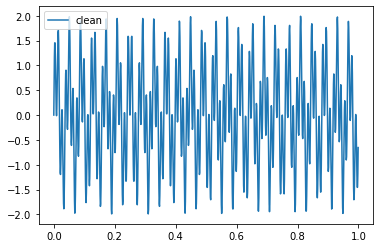

In [4]:
dt = 0.001; sampling_index = 1
domain = torch.tensor(np.arange(0, 1, dt))
plt.plot(domain, f_clean_data[sampling_index], label='clean')
plt.legend()
plt.show()

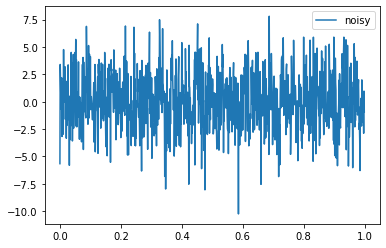

In [5]:
plt.plot(domain, f_data[sampling_index], label='noisy')
plt.legend()
plt.show()

In [6]:
sig = f_data[sampling_index]
clean_sig = f_clean_data[sampling_index]

In [7]:
# FFT will not working, if the signal is shuffled.
# sig = sig[torch.randperm(sig.shape[0])]

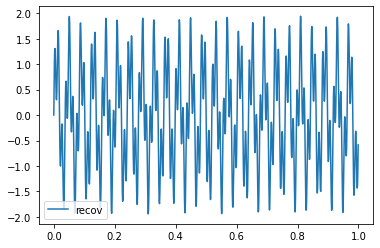

In [8]:
thres = 100
fft = torch.fft.fft(sig)
PSD = (1/len(domain))*torch.abs(fft)**2
recov_sig = torch.fft.ifft((PSD > thres)*fft).real

plt.plot(domain, recov_sig, label='recov')
plt.legend()
plt.show()

In [9]:
F.mse_loss(recov_sig, clean_sig).item()

0.029348483309149742

#### Notes

    - If the features are independent, it is quite hard to recover using AutoEncoder.
    - Even when there are some relationship between the features, NN requires a large size of training set.

In [10]:
# Linear AE
class AutoEncoder(nn.Module):
    def __init__(self, inp_dims=100, n_hiddens=32):
        super(AutoEncoder, self).__init__()
        self.enc = nn.Sequential(nn.Linear(inp_dims, n_hiddens), nn.Tanh())
        self.dec = nn.Sequential(nn.Linear(n_hiddens, inp_dims))
    def forward(self, X):
        return self.dec(self.enc(X))

In [11]:
inp = f_data.unsqueeze(-1)

In [12]:
sequences = inp[sampling_index].tolist()

In [13]:
encoded, decoded, final_loss  = QuickEncode(sequences, embedding_dim=2)

epoch : 100, loss_mean : 6.7447515
epoch : 200, loss_mean : 6.4135184
epoch : 300, loss_mean : 5.9007540
epoch : 400, loss_mean : 5.2677922
epoch : 500, loss_mean : 4.5588932
epoch : 600, loss_mean : 3.8227711
epoch : 700, loss_mean : 3.1067543
epoch : 800, loss_mean : 2.4608376
epoch : 900, loss_mean : 1.9164602
epoch : 1000, loss_mean : 1.4745595
epoch : 1100, loss_mean : 1.0908304
epoch : 1200, loss_mean : 0.7657201
epoch : 1300, loss_mean : 0.5475741
epoch : 1400, loss_mean : 0.3959027
epoch : 1500, loss_mean : 0.2804700
epoch : 1600, loss_mean : 0.1961122
epoch : 1700, loss_mean : 0.1367575
epoch : 1800, loss_mean : 0.0965090
epoch : 1900, loss_mean : 0.0700906
epoch : 2000, loss_mean : 0.0527724
epoch : 2100, loss_mean : 0.0409514
epoch : 2200, loss_mean : 0.0326685
epoch : 2300, loss_mean : 0.0267098
epoch : 2400, loss_mean : 0.0223063
epoch : 2500, loss_mean : 0.0189664
epoch : 2600, loss_mean : 0.0163717
epoch : 2700, loss_mean : 0.0143124
epoch : 2800, loss_mean : 0.0126467
e

5.888980865478516


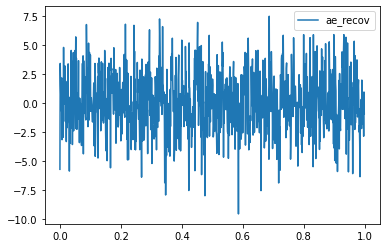

In [14]:
# Overfitting to the data...
print(F.mse_loss(decoded, clean_sig).item())
plt.plot(domain, decoded.detach(), label='ae_recov')
plt.legend()
plt.show()